#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Необходимые библиотеки

Установим и импортируем необходимые библиотеки.

In [1]:
#!pip install pandas-profiling

In [1]:
import time
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

Загрузим данные, предусмотрим различные способы расположения файлов.

In [2]:
try:
    taxi = pd.read_csv('taxi.csv')
except:
    taxi = pd.read_csv('/datasets/taxi.csv')

Проверим читаемость данных.

In [3]:
taxi.sample(5)

,datetime,num_orders
18315,2018-07-06 04:30:00,14
2576,2018-03-18 21:20:00,14
2484,2018-03-18 06:00:00,1
20484,2018-07-21 06:00:00,9
1107,2018-03-08 16:30:00,13


Описание данных

Признаки

    datetime — отметка времени

Целевой признак

    num_orders - количество заказов

Данные читаемы, описанию соответствуют.

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет.

Приведем значения в графе datetime к соответствующему типу данных.

In [5]:
FORMAT_DATETIME = '%Y-%m-%dT%H:%M:%S'

In [6]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'], format=FORMAT_DATETIME)

Проиндексируем датафрейм по признаку 'datetime'

In [7]:
taxi = taxi.set_index('datetime').sort_index()

Выполним ресемплирование по одному часу.

In [8]:
taxi.index.is_monotonic

True

In [9]:
taxi = taxi.resample('1H').sum()

In [10]:
taxi.shape

(4416, 1)

### Вывод

Предоставленные данные содержат информацию о количестве заказов такси за 26 496 временных отметок, взятых с интервалом в 10 минут, пропуски отсутствуют.

Былы проведены преобразование значений времени к соответствующему типу данных, проверка на монотонность и ресемплирование с периодом 1 час.

Данные подготовлены, можно приступать к их анализу.

## Анализ

### EDA средствами pandas-profiling

С помощью средств библиотеки pandas_profiling проанализируем данные.

In [11]:
profile = taxi.profile_report()

In [12]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. Данные охватывают период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.
2. Значения правдоподобны (от 0 до 462 заказов в час), распределены нормально.

### Cкользящее среднее

Выведем графики скользящего среднего с различными периодами усреднения:
- 1 час (без усреднения), 
- 1 день, 
- 1 неделя, 
- 1 месяц.

In [13]:
%matplotlib inline

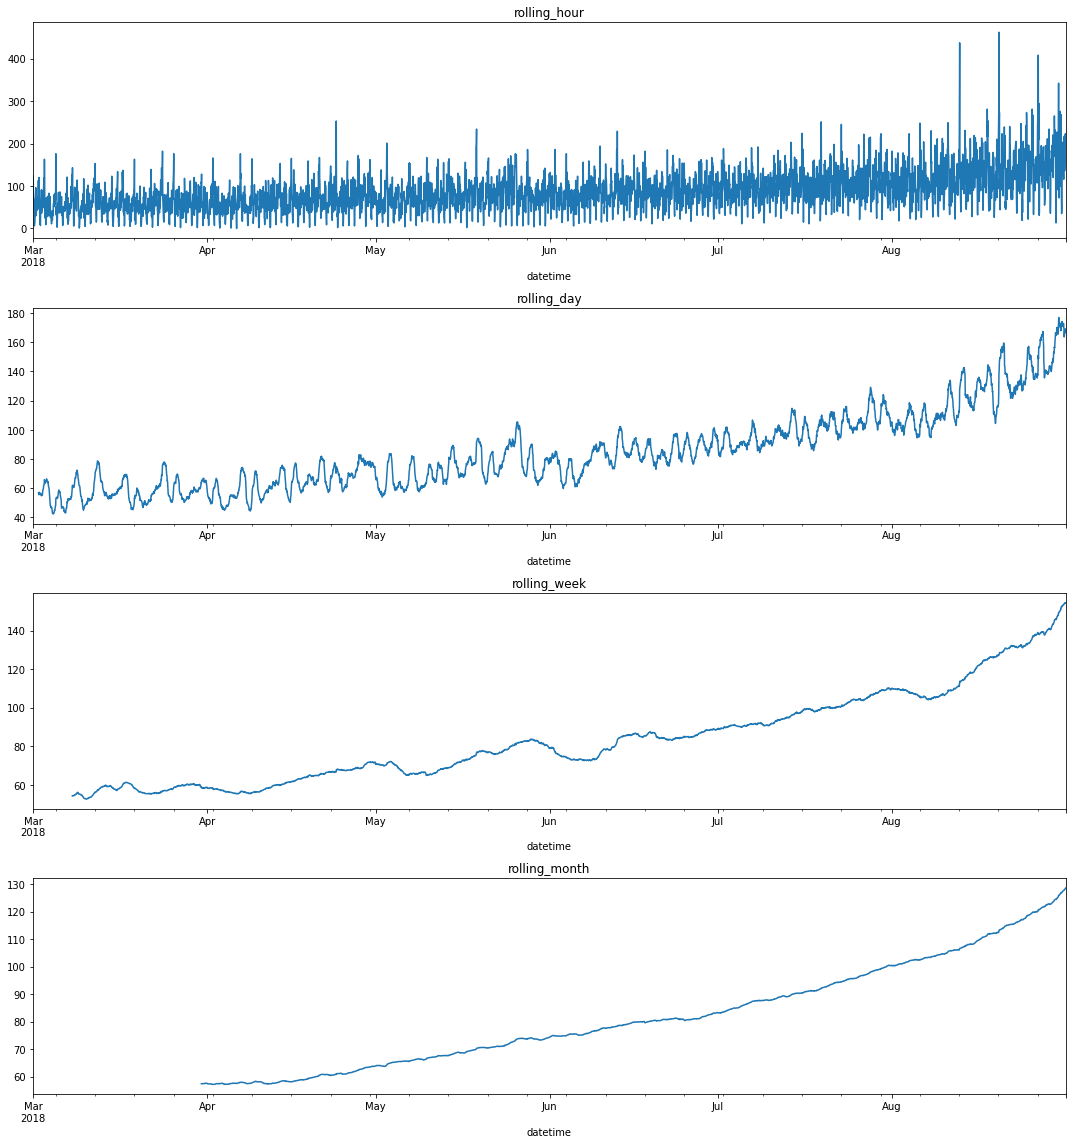

In [14]:
plt.figure(figsize=(15, 16))
plt.subplot(411)
taxi['num_orders'].plot(ax=plt.gca())
plt.title('rolling_hour')
plt.subplot(412)
taxi['num_orders'].rolling(24).mean().plot(ax=plt.gca())
plt.title('rolling_day')
plt.subplot(413)
taxi['num_orders'].rolling(24 * 7).mean().plot(ax=plt.gca())
plt.title('rolling_week')
plt.subplot(414)
taxi['num_orders'].rolling(24 * 30).mean().plot(ax=plt.gca())
plt.title('rolling_month')

plt.tight_layout()

Можем заметить, что имеется явно выраженный возрастающий тренд. Траектория близка к линейной.

### Разложение временного ряда на тренд, сезонность и остаток

С помощью функции seasonal_decompose разложим временной ряд на составляющие. 

Для большей наглядности выведем графики для различных периодов:
- все имеющиеся данные (пол года),
- месяц,
- неделя.

Все данные.

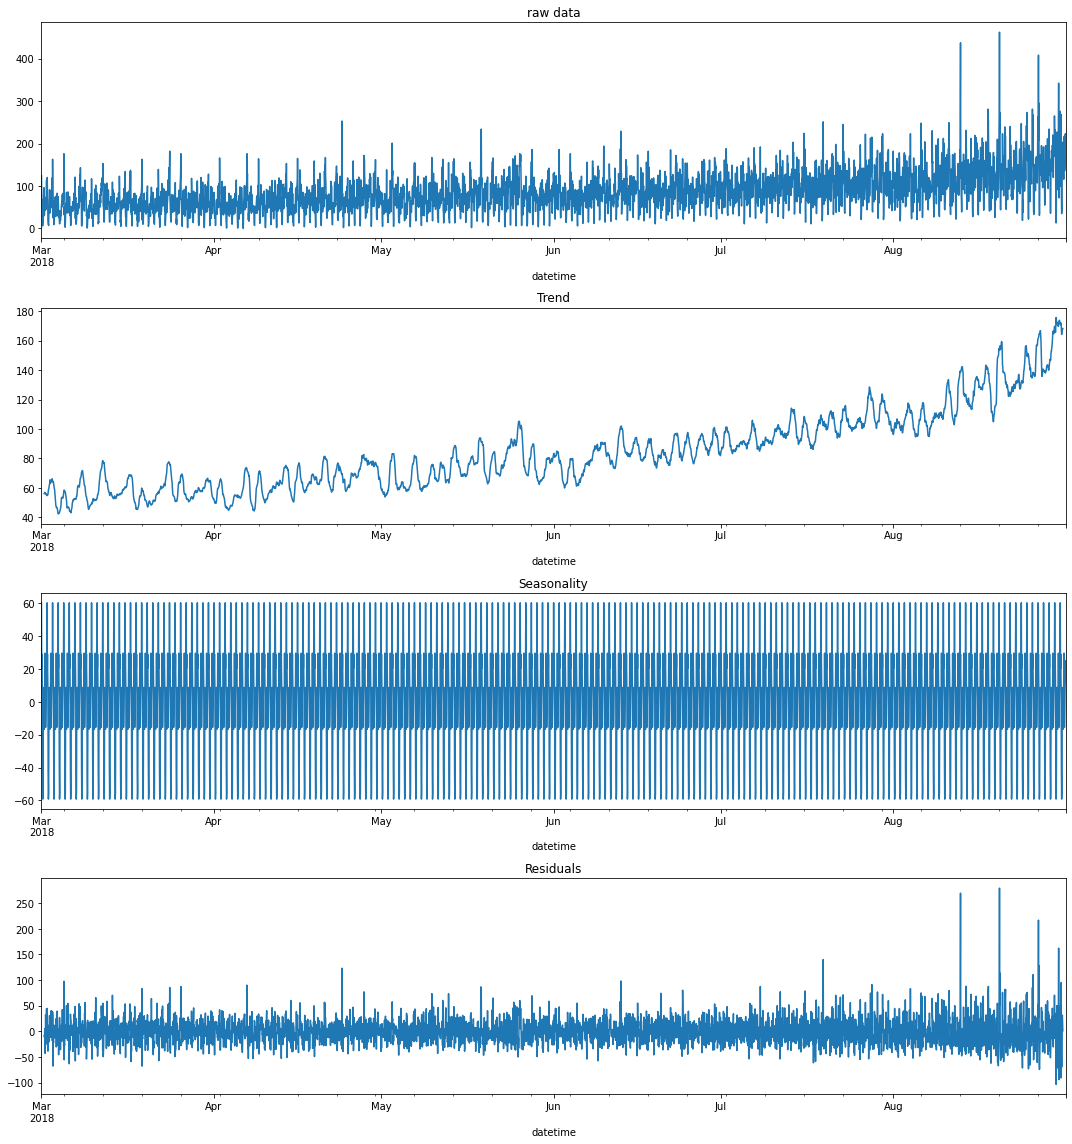

In [15]:
decomposed = seasonal_decompose(taxi['num_orders'])

plt.figure(figsize=(15, 16))
plt.subplot(411)
taxi['num_orders'].plot(ax=plt.gca())
plt.title('raw data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

На данном масштабе можем отметить явный возрастающий тренд и наличие сезонности, период которой при таком масштабе определить затруднительно. Случайные колебания (шум) составляют примерно +-50 заказов в час, к концу исследуемого периода шум имеет тенденцию к нарастанию. 

Теперь рассмотрим данные в масштабе 1 месяца.

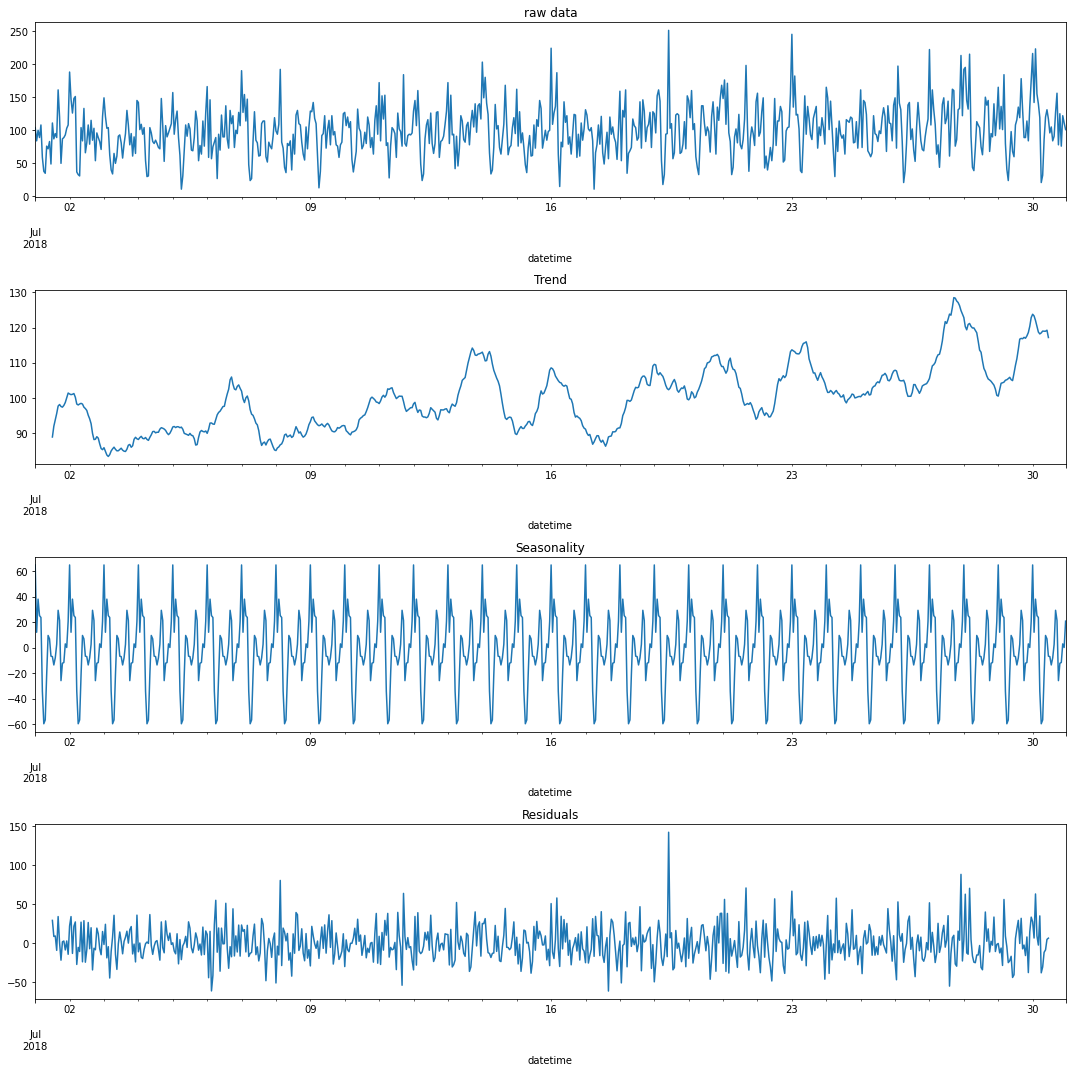

In [16]:
decomposed = seasonal_decompose(taxi['num_orders'].loc['2018-07-01':'2018-07-30'])

plt.figure(figsize=(15, 15))
plt.subplot(411)
taxi['num_orders'].loc['2018-07-01':'2018-07-30'].plot(ax=plt.gca())
plt.title('raw data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

На масштабе 1 месяц тренд сохраняет восходящее направление, сезонность имеет суточный характер, разброс шума прежний.

Теперь рассмотрим данные в масштабе 1 недели.

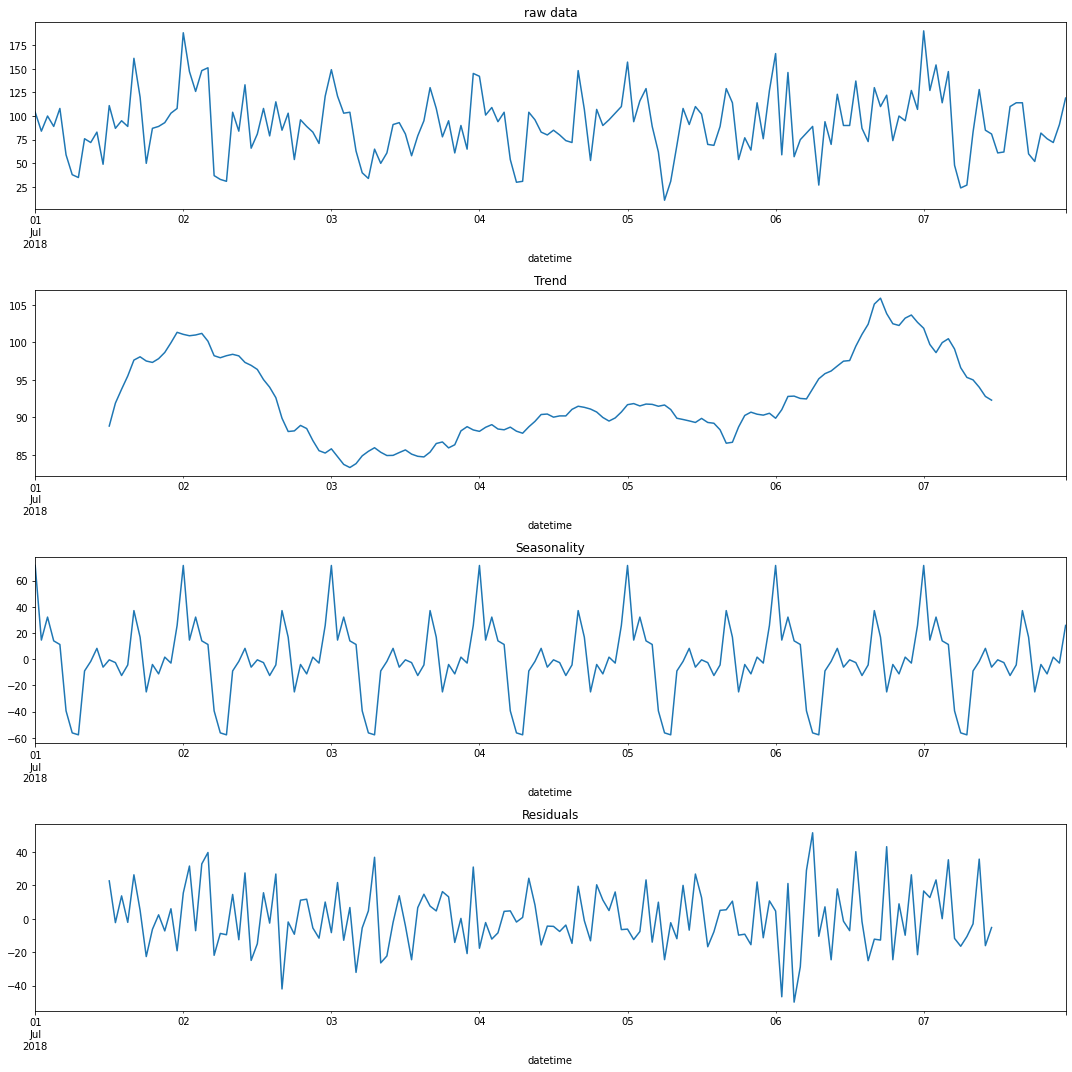

In [17]:
decomposed = seasonal_decompose(taxi['num_orders'].loc['2018-07-01':'2018-07-07'])

plt.figure(figsize=(15, 15))
plt.subplot(411)
taxi['num_orders'].loc['2018-07-01':'2018-07-07'].plot(ax=plt.gca())
plt.title('raw data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

resid = decomposed.resid

На этом масштабе направление тренда определить уже затруднительно, сезонность видна еще отчетливее, разброс шума сократился.

В масштабе двух суток, чтобы увидеть пики в определенное время.

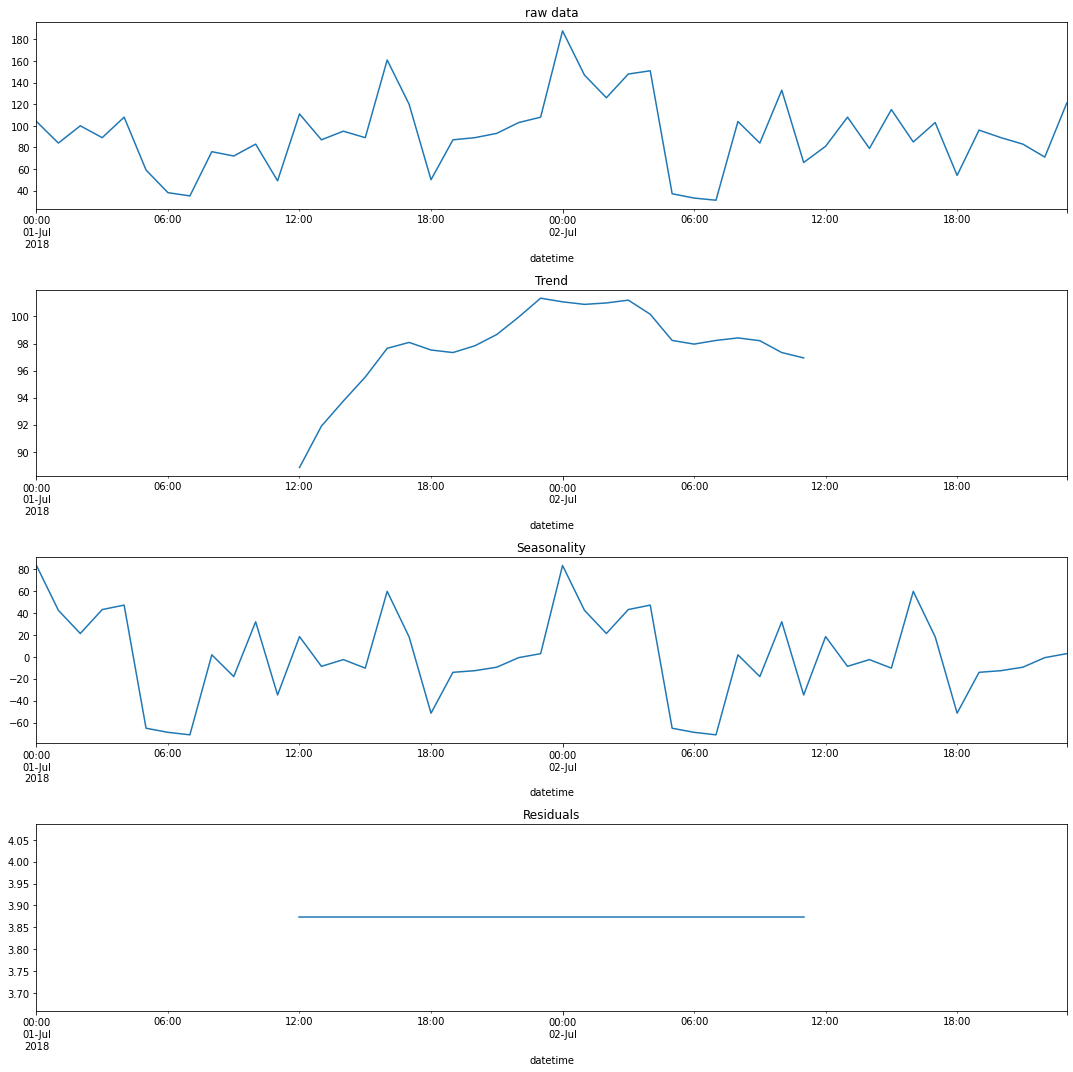

In [18]:
decomposed = seasonal_decompose(taxi['num_orders'].loc['2018-07-01 00':'2018-07-02 23'])

plt.figure(figsize=(15, 15))
plt.subplot(411)
taxi['num_orders'].loc['2018-07-01 00':'2018-07-02 23'].plot(ax=plt.gca())
plt.title('raw data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [19]:
# расчет RMSE шума
s = 0
n = 0

for i in range(12, 156): # первые и последние значения отбрасываем (np.nan'ы)
    s += (resid[i]) ** 2
    n += 1
print((s / n) ** .5)
    

18.45936097791221


Таким образом в результате обучения модель должна как можно точнее уловить тренд (график которого близок к линейному) и наложить на него внутрисуточные колебания. Ошибка прогноза в таком случае будет равна шуму (примерно +-20 вызовов в час). 

### Вывод

Данные охватывают период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00. Значения правдоподобны (от 0 до 462 заказов в час), распределены нормально.

С помощью скользящего среднего выявлено, что имеется явно выраженный возрастающий тренд, его траектория близка к линейной.

Выполнено разложение временного ряда на тренд, сезонность и остаток. Выявлен явный возрастающий тренд и наличие сезонности. Случайные колебания (шум) составляют примерно +-50 заказов в час, к концу исследуемого периода шум имеет тенденцию к нарастанию, сезонность имеет суточный характер.

## Построение и отбор признаков

### Формирование признаков

Напишем функцию, автоматизирующую формирование дополнительных признаков.

In [20]:
def make_features(max_lag, rolling_mean_size):
    
    # taxi['year'] = taxi.index.year
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['hour'] = taxi.index.hour
    taxi['day_of_year'] = taxi.index.day_of_year
    taxi['day_of_week'] = taxi.index.day_of_week
    # taxi['quarter'] = taxi.index.quarter
    
    taxi['is_month_start'] = taxi.index.is_month_start
    taxi['is_month_end'] = taxi.index.is_month_end
    # taxi['is_quarter_start'] = taxi.index.is_quarter_start
    # taxi['is_quarter_end'] = taxi.index.is_quarter_end
    # taxi['is_year_start'] = taxi.index.is_year_start
    # taxi['is_year_end'] = taxi.index.is_year_end
    
       
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

   
    
    for size in rolling_mean_size:
        taxi['rolling_mean_{}'.format(size)] = taxi['num_orders'].shift().rolling(size).mean()

Применим финкцию для лага 200 и скользящих средних 5 и 73.

In [21]:
make_features(200, [5, 73])

### Подготовка данных для обучения моделей

Разделим данные на тренировочную и тестовую выборку для временных рядов (без перетасовки)

In [22]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

Избавимся от пропусков

In [23]:
train = train.dropna()

Выделим целевой признак в обеих выборках.

In [24]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

<a id="scaled"></a>
Выполним масштабирование признаков.

In [25]:
%%time

scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

CPU times: user 129 ms, sys: 49.3 ms, total: 178 ms
Wall time: 183 ms


### Вывод

Сформированы calendar, lag и rolling features.

Данные разделены на обучающую и тестовую выборки.

Целевой признак отделен от остальных.

Выполнено масштабирование значений.

Пропусков нет.

Можно приступать к обучению моделей.

## Обучение моделей

Подготовим таблицу для занесения результатов.

In [26]:
results = pd.DataFrame()

### Проверка на вменяемость

Выявим пороговые значения, хуже которых результаты быть не должны.

Предсказание по медиане.

In [27]:
result_median = ['median']

In [28]:
start_time = time.perf_counter()
target_median = train['num_orders'].median()
result_median.append(time.perf_counter() - start_time)

In [29]:
start_time = time.perf_counter()
y_pred = pd.Series(target_median, index=test.index)
result_median.append(time.perf_counter() - start_time)

In [30]:
rmse = mean_squared_error(test['num_orders'], y_pred, squared=False)
result_median.append(rmse)
results = results.append([result_median], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_median))

model: median, fit_time: 0.001, predict_time: 0.001, rmse: 86


Предсказание по предыдущему значению.

In [31]:
result_previous = ['previous']

In [32]:
start_time = time.perf_counter()
pred_previous = test['num_orders'].shift()
result_previous.append(time.perf_counter() - start_time)

In [33]:
start_time = time.perf_counter()
pred_previous.iloc[0]=train['num_orders'].iloc[-1]
result_previous.append(time.perf_counter() - start_time)

In [34]:
rmse = mean_squared_error(test['num_orders'], pred_previous, squared=False)
result_previous.append(rmse)
results = results.append([result_previous], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_previous))

model: previous, fit_time: 0.001, predict_time: 0.000, rmse: 59


### LinearRegression

В дальнейшем будем использовать кросс-валидацию, поэтому введем параметр tscv, отражающий особенности этого механизма для TimeSeries.

In [35]:
tscv = TimeSeriesSplit(n_splits=3)

Для алгоритма LinearRegression() выполним подбор оптимальных гиперпараметров.

In [36]:
result_linear_regression = ['linear_regression']

In [37]:
linear_regression = LinearRegression()

In [38]:
parametrs = {'fit_intercept': ['True', 'False']}

In [39]:
%%time

linear_regression_grid = GridSearchCV(linear_regression, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
linear_regression_grid.fit(X_train, y_train)
best_linear_regression = linear_regression_grid.best_estimator_
linear_regression_grid.best_params_

CPU times: user 2.96 s, sys: 3.65 s, total: 6.61 s
Wall time: 6.56 s


{'fit_intercept': 'True'}

Замерим показатели модели с оптимальными гиперпараметрами.

In [40]:
start_time = time.perf_counter()
best_linear_regression.fit(X_train, y_train)
result_linear_regression.append(time.perf_counter() - start_time)

In [41]:
start_time = time.perf_counter()
y_pred_test = best_linear_regression.predict(X_test)
result_linear_regression.append(time.perf_counter() - start_time)

In [42]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_linear_regression.append(rmse)
results = results.append([result_linear_regression], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_linear_regression))

model: linear_regression, fit_time: 0.983, predict_time: 0.109, rmse: 35


In [38]:
parametrs = {'fit_intercept': ['True', 'False']}

%%time

linear_regression_grid = GridSearchCV(linear_regression, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
linear_regression_grid.fit(X_train, y_train)
best_linear_regression = linear_regression_grid.best_estimator_
linear_regression_grid.best_params_

Замерим показатели модели с оптимальными гиперпараметрами.

start_time = time.perf_counter()
best_linear_regression.fit(X_train, y_train)
result_linear_regression.append(time.perf_counter() - start_time)

start_time = time.perf_counter()
y_pred_test = best_linear_regression.predict(X_test)
result_linear_regression.append(time.perf_counter() - start_time)

rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_linear_regression.append(rmse)
results = results.append([result_linear_regression], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_linear_regression))

<a id="linear_regression_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [43]:
result_linear_regression_scaled = ['linear_regression_scaled']

In [44]:
linear_regression_scaled = LinearRegression()

In [45]:
start_time = time.perf_counter()
linear_regression_scaled.fit(X_train_scaled, y_train)
result_linear_regression_scaled.append(time.perf_counter() - start_time)

In [46]:
start_time = time.perf_counter()
y_pred_test = linear_regression_scaled.predict(X_test_scaled)
result_linear_regression_scaled.append(time.perf_counter() - start_time)

In [47]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_linear_regression_scaled.append(rmse)
results = results.append([result_linear_regression_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_linear_regression_scaled))

model: linear_regression_scaled, fit_time: 1.676, predict_time: 0.096, rmse: 35


Результаты работы LinearRegression():

для немасштабированных данных:

- fit_time: 0.129, 
- predict_time: 0.018, 
- rmse: 35

для масштабированных данных:

- fit_time: 0.030, 
- predict_time: 0.002, 
- rmse: 36


Использование StandardScaler() не улучшает точность предсказания LinearRegression()

### Ridge

Для алгоритма Ridge() выполним подбор оптимальных гиперпараметров.

In [48]:
result_ridge = ['ridge']

In [49]:
ridge = Ridge()

In [50]:
parametrs = {'alpha': [0.05, 0.2, 0.99]}

In [51]:
%%time

ridge_grid = GridSearchCV(ridge, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
ridge_grid.best_params_

CPU times: user 1.96 s, sys: 2.45 s, total: 4.42 s
Wall time: 4.42 s


{'alpha': 0.99}

Замерим показатели модели с оптимальными гиперпараметрами.

In [52]:
start_time = time.perf_counter()
best_ridge.fit(X_train, y_train)
result_ridge.append(time.perf_counter() - start_time)

In [53]:
start_time = time.perf_counter()
y_pred_test = best_ridge.predict(X_test)
result_ridge.append(time.perf_counter() - start_time)

In [54]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_ridge.append(rmse)
results = results.append([result_ridge], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_ridge))

model: ridge, fit_time: 0.204, predict_time: 0.185, rmse: 35


<a id="ridge_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [55]:
result_ridge_scaled = ['ridge_scaled']

In [56]:
ridge_scaled = Ridge(alpha=0.99)

In [57]:
start_time = time.perf_counter()
ridge_scaled.fit(X_train_scaled, y_train)
result_ridge_scaled.append(time.perf_counter() - start_time)

In [58]:
start_time = time.perf_counter()
y_pred_test = ridge_scaled.predict(X_test_scaled)
result_ridge_scaled.append(time.perf_counter() - start_time)

In [59]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_ridge_scaled.append(rmse)
results = results.append([result_ridge_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_ridge_scaled))

model: ridge_scaled, fit_time: 0.096, predict_time: 0.094, rmse: 35


Результаты работы Ridge():

для немасштабированных данных:

- fit_time: 0.078, 
- predict_time: 0.010, 
- rmse: 35

для масштабированных данных:

- fit_time: 0.014, 
- predict_time: 0.001, 
- rmse: 35


Использование StandardScaler() не улучшает точность предсказания Ridge()

### ElasticNet

Для алгоритма ElasticNet() выполним подбор оптимальных гиперпараметров.

In [60]:
result_elastic = ['elastic']

In [61]:
elastic = ElasticNet() 

In [62]:
%%time

elastic_grid = GridSearchCV(elastic, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
elastic_grid.fit(X_train, y_train)
best_elastic = elastic_grid.best_estimator_
elastic_grid.best_params_

CPU times: user 21.6 s, sys: 28.3 s, total: 49.9 s
Wall time: 50.3 s


{'alpha': 0.99}

Замерим показатели модели с оптимальными гиперпараметрами.

In [63]:
start_time = time.perf_counter()
best_elastic.fit(X_train, y_train)
result_elastic.append(time.perf_counter() - start_time)

In [64]:
start_time = time.perf_counter()
y_pred_test = best_elastic.predict(X_test)
result_elastic.append(time.perf_counter() - start_time)

In [65]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_elastic.append(rmse)
results = results.append([result_elastic], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_elastic))

model: elastic, fit_time: 11.789, predict_time: 0.181, rmse: 35


<a id="elastic_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [66]:
result_elastic_scaled = ['elastic_scaled']

In [67]:
elastic_scaled = ElasticNet(alpha=0.99)

In [68]:
start_time = time.perf_counter()
elastic_scaled.fit(X_train_scaled, y_train)
result_elastic_scaled.append(time.perf_counter() - start_time)

In [69]:
start_time = time.perf_counter()
y_pred_test = elastic_scaled.predict(X_test_scaled)
result_elastic_scaled.append(time.perf_counter() - start_time)

In [70]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_elastic_scaled.append(rmse)
results = results.append([result_elastic_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_elastic_scaled))

model: elastic_scaled, fit_time: 0.073, predict_time: 0.003, rmse: 61


Результаты работы ElasticNet():

для немасштабированных данных:

- fit_time: 0.737, 
- predict_time: 0.009, 
- rmse: 35

для масштабированных данных:

- fit_time: 0.055, 
- predict_time: 0.001, 
- rmse: 37


Использование StandardScaler() не улучшает точность предсказания ElasticNet()

### LightGBM

Для алгоритма LGBMRegressor() выполним подбор оптимальных гиперпараметров.

In [71]:
result_lgb_regressor = ['lgb_regressor']

In [72]:
lgb_regressor = lgb.LGBMRegressor()

In [73]:
parametrs = {'boosting_type': ['gbdt', 'dart', 'goss'],
             'learning_rate': [.01, .05],
             'n_estimators': [10, 100] }

In [74]:
%%time

lgb_regressor_grid = GridSearchCV(lgb_regressor, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_regressor_grid.fit(X_train, y_train)
best_lgb_regressor = lgb_regressor_grid.best_estimator_
lgb_regressor_grid.best_params_

CPU times: user 8min 24s, sys: 1.86 s, total: 8min 26s
Wall time: 8min 33s


{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 100}

Замерим показатели модели с оптимальными гиперпараметрами.

In [75]:
start_time = time.perf_counter()
best_lgb_regressor.fit(X_train, y_train)
result_lgb_regressor.append(time.perf_counter() - start_time)

In [76]:
start_time = time.perf_counter()
y_pred_test = best_lgb_regressor.predict(X_test)
result_lgb_regressor.append(time.perf_counter() - start_time)

In [77]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_lgb_regressor.append(rmse)
results = results.append([result_lgb_regressor], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_lgb_regressor))

model: lgb_regressor, fit_time: 23.106, predict_time: 0.013, rmse: 37


Результаты работы LGBMRegressor():

- fit_time: 0.718, 
- predict_time: 0.013, 
- rmse: 37

### RandomForestRegressor

In [78]:
result_rf_regressor = ['rf_regressor']

In [79]:
rf_regressor = RandomForestRegressor()

In [80]:
parametrs = {'max_depth': [5, 10, 20],
             'n_estimators': [5, 10, 20] }

In [81]:
%%time

rf_regressor_grid = GridSearchCV(rf_regressor, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_regressor_grid.fit(X_train, y_train)
best_rf_regressor = rf_regressor_grid.best_estimator_
rf_regressor_grid.best_params_

CPU times: user 44.7 s, sys: 0 ns, total: 44.7 s
Wall time: 45.5 s


{'max_depth': 10, 'n_estimators': 20}

In [82]:
start_time = time.perf_counter()
best_rf_regressor.fit(X_train, y_train)
result_rf_regressor.append(time.perf_counter() - start_time)

In [83]:
start_time = time.perf_counter()
y_pred_test = best_rf_regressor.predict(X_test)
result_rf_regressor.append(time.perf_counter() - start_time)

In [84]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_rf_regressor.append(rmse)
results = results.append([result_rf_regressor], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_rf_regressor))

model: rf_regressor, fit_time: 5.695, predict_time: 0.012, rmse: 40


Результаты работы RandomForestRegressor():

- fit_time: 5.126, 
- predict_time: 0.014, 
- rmse: 45

### CatBoostRegressor

In [85]:
result_cat_regressor = ['cat_regressor']

In [86]:
cat_regressor = CatBoostRegressor()

In [87]:
parametrs = {'boosting_type': ['Ordered', 'Plain'],
             'learning_rate': [.01, .05],
             'n_estimators': [10, 100],
             'loss_function': ['RMSE'],
             'verbose': [10]}

In [88]:
%%time

cat_regressor_grid = GridSearchCV(cat_regressor, parametrs, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cat_regressor_grid.fit(X_train, y_train)
best_cat_regressor = cat_regressor_grid.best_estimator_
cat_regressor_grid.best_params_

0:	learn: 29.2409749	total: 260ms	remaining: 2.34s
9:	learn: 28.0437988	total: 1.48s	remaining: 0us
0:	learn: 32.7953118	total: 253ms	remaining: 2.27s
9:	learn: 31.3603451	total: 1.73s	remaining: 0us
0:	learn: 33.7722014	total: 284ms	remaining: 2.56s
9:	learn: 32.2311556	total: 1.96s	remaining: 0us
0:	learn: 29.2409749	total: 215ms	remaining: 21.3s
10:	learn: 27.9181969	total: 1.56s	remaining: 12.6s
20:	learn: 26.6932978	total: 2.91s	remaining: 11s
30:	learn: 25.5946617	total: 4.52s	remaining: 10.1s
40:	learn: 24.6131095	total: 5.94s	remaining: 8.55s
50:	learn: 23.7654445	total: 7.4s	remaining: 7.11s
60:	learn: 22.9598058	total: 8.78s	remaining: 5.61s
70:	learn: 22.2546702	total: 10.2s	remaining: 4.16s
80:	learn: 21.6372120	total: 11.5s	remaining: 2.71s
90:	learn: 21.0344396	total: 12.9s	remaining: 1.27s
99:	learn: 20.5479605	total: 14.1s	remaining: 0us
0:	learn: 32.7953118	total: 266ms	remaining: 26.3s
10:	learn: 31.2131741	total: 1.93s	remaining: 15.7s
20:	learn: 29.7838905	total: 3.

{'boosting_type': 'Ordered',
 'learning_rate': 0.05,
 'loss_function': 'RMSE',
 'n_estimators': 100,
 'verbose': 10}

In [89]:
start_time = time.perf_counter()
best_cat_regressor.fit(X_train, y_train)
result_cat_regressor.append(time.perf_counter() - start_time)

0:	learn: 37.6560953	total: 338ms	remaining: 33.5s
10:	learn: 29.8482950	total: 2.53s	remaining: 20.5s
20:	learn: 25.5580561	total: 4.71s	remaining: 17.7s
30:	learn: 23.2517580	total: 6.87s	remaining: 15.3s
40:	learn: 22.0260019	total: 9.44s	remaining: 13.6s
50:	learn: 21.3505589	total: 11.6s	remaining: 11.2s
60:	learn: 20.9409828	total: 13.8s	remaining: 8.85s
70:	learn: 20.6405218	total: 16s	remaining: 6.52s
80:	learn: 20.4035225	total: 18.1s	remaining: 4.25s
90:	learn: 20.2024903	total: 20.3s	remaining: 2s
99:	learn: 20.0191702	total: 22.2s	remaining: 0us


In [90]:
start_time = time.perf_counter()
y_pred_test = best_cat_regressor.predict(X_test)
result_cat_regressor.append(time.perf_counter() - start_time)

In [91]:
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
result_cat_regressor.append(rmse)
results = results.append([result_cat_regressor], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_cat_regressor))

model: cat_regressor, fit_time: 23.245, predict_time: 0.010, rmse: 41


Результаты работы CatBoostRegressor():

- fit_time: 12.207, 
- predict_time: 0.018, 
- rmse: 40

## Анализ моделей

Обобщим полученные результаты в таблице.

In [92]:
results.columns=['model', 'fit_time', 'predict_time', 'rmse']

In [93]:
results = results.set_index('model')

In [94]:
results.style.format({'fit_time': '{:.3f}', 'predict_time': '{:.3f}', 'rmse': '{:.0f}'})

,fit_time,predict_time,rmse
model,,,
median,0.001,0.001,86
previous,0.001,0.000,59
linear_regression,0.983,0.109,35
linear_regression_scaled,1.676,0.096,35
ridge,0.204,0.185,35
ridge_scaled,0.096,0.094,35
elastic,11.789,0.181,35
elastic_scaled,0.073,0.003,61
lgb_regressor,23.106,0.013,37


Отобразим результаты графически.

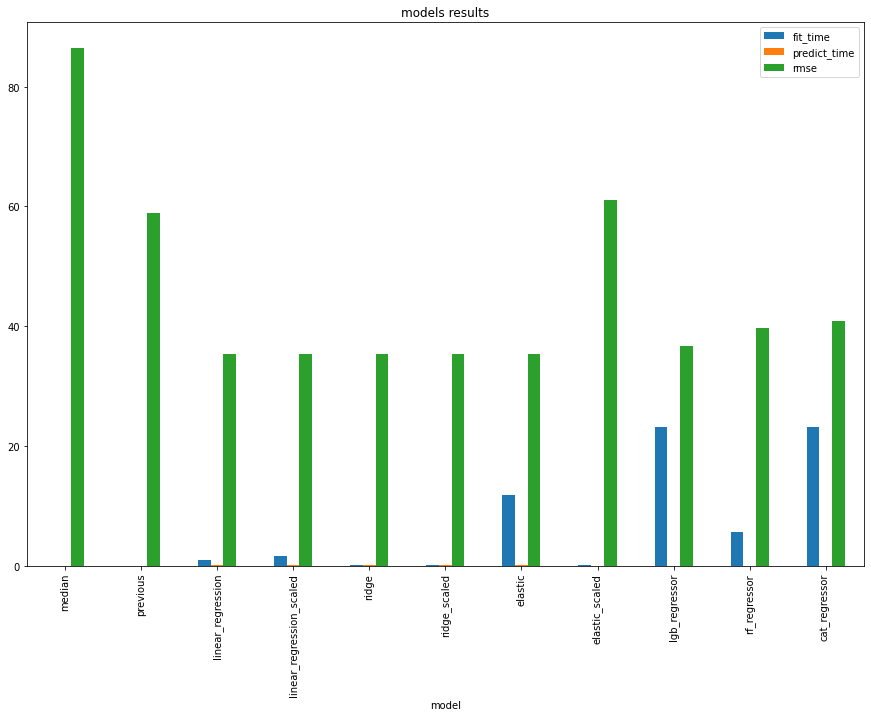

In [95]:
results.plot(kind='bar', ax=plt.gca(), figsize=(15, 10))
plt.title('models results')
plt.show()

Все модели прошли проверку на адекватность.

По качеству предсказания по метрике RMSE выигрывают линейные модели, с учетом времени работы, лучший результат у алгоритма Ridge.

Скорость работы на масштабированных данных выше, но с учетом времени, потраченного на масштабирование, выигрыш не очевиден.

Алгоритмы градиентного бустинга и случайного леса проигрывают как по качеству результата, так и по затраченному времени.

## Вывод

Все испытанные модели показали начение метрики RMSE на тестовой выборке не больше 48.

Лучшие результаты у модели на основе алгоритма Ridge:

- fit_time: 0.078, 
- predict_time: 0.010, 
- rmse: 35

Именно эту модель рекомендуется использовать для прогнозирования количества заказов такси на следующий час.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48